**Prática 08 – Regressão Logistica**

**Alunos:

GIOVANNI SURIANI FERREIRA

JORGE ALIOMAR TROCOLI ABDON DANTAS**

Objetivo:<br>
- Aplique classificador Regressão Logística aos dados seu Trabalho Prático.
    - (https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- Compare os resultados da Regressão Logística com os resultados do XGBoost (ou equivalente)

# PREPARAÇÃO DA BASE DE DADOS - Todos os dados

In [1]:
#Importando Bibliotecas Pandas e Numpy
import pandas as pd
import numpy as np


# Otimizador Giovanni
from sklearnex import patch_sklearn
patch_sklearn()

#CSV_PATH = "/home/gi/Desktop/Semestre8/Inteligencia_Computacional/TP1_csvs" # Path Giovanni
#validacao_cruzada_num_folds = 10 # Para Giovanni
#CSV_PATH = "E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/" # Path Jorge
CSV_PATH = "C:/Users/LUCAR/Documents/Jorge/IC/bases" # Path Jorge
validacao_cruzada_num_folds = 10     # Para Jorge

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
#Carregando Base de dados principal - Treino
df_train = pd.read_csv(f"{CSV_PATH}/df_train_full.csv")
df_test  = pd.read_csv(f"{CSV_PATH}/df_test_full.csv")

# PREPARAÇÃO DA BASE DE DADOS - Amostra

## Verificação com colunas com muitos nulos (mais que 25%)

In [3]:
#Calcular o % de nulos por coluna
percentual_nulos = round(df_train.isnull().mean(),2)

# Verificar quais colunas têm mais de 25% de valores nulos
colunas_com_muitos_nulos = percentual_nulos[percentual_nulos > 0.25].index.tolist()

## Exclusão das coluna com muitos nulos

In [4]:
df_train_tratado = df_train.copy()
df_test_tratado  = df_test.copy()

# Excluir colunas do treino
df_train_tratado = df_train_tratado.drop(columns=colunas_com_muitos_nulos)

# Excluir colunas do teste
df_test_tratado = df_test_tratado.drop(columns=colunas_com_muitos_nulos)

## Substitutição dos nulos

In [5]:
#Tratar colunas numéricas - Treino
for coluna in df_train_tratado.select_dtypes(include=['number']).columns:
    if df_train_tratado[coluna].isnull().any():
        if pd.api.types.is_float_dtype(df_train_tratado[coluna]): # Se tipo de dado for float, realizará a média
            media = df_train_tratado[coluna].mean()
            df_train_tratado[coluna] = df_train_tratado[coluna].fillna(media)
        elif pd.api.types.is_integer_dtype(df_train_tratado[coluna]): # Se tipo de dado for int, realizará a moda
            moda = df_train_tratado[coluna].mode(dropna=True)
            if not moda.empty:
                df_train_tratado[coluna] = df_train_tratado[coluna].fillna(moda[0])

#Tratar colunas categóricas com a moda  - Treino
colunas_categoricas = df_train_tratado.select_dtypes(include=['object', 'category']).columns

for coluna in colunas_categoricas:
    if df_train_tratado[coluna].isnull().any():
        moda = df_train_tratado[coluna].mode(dropna=True)
        if not moda.empty:
            df_train_tratado[coluna] = df_train_tratado[coluna].fillna(moda[0])

#Validação - Treino
print("Total de valores nulos restantes nos dados de treino:", df_train_tratado.isnull().sum().sum())

Total de valores nulos restantes nos dados de treino: 0


In [6]:
#Tratar colunas numéricas - Teste
for coluna in df_test_tratado.select_dtypes(include=['number']).columns:
    if df_test_tratado[coluna].isnull().any():
        if pd.api.types.is_float_dtype(df_test_tratado[coluna]): # Se tipo de dado for float, realizará a média
            media = df_test_tratado[coluna].mean()
            df_test_tratado[coluna] = df_test_tratado[coluna].fillna(media)
        elif pd.api.types.is_integer_dtype(df_test_tratado[coluna]): # Se tipo de dado for int, realizará a moda
            moda = df_test_tratado[coluna].mode(dropna=True)
            if not moda.empty:
                df_test_tratado[coluna] = df_test_tratado[coluna].fillna(moda[0])

#Tratar colunas categóricas com a moda  - Teste
colunas_categoricas = df_test_tratado.select_dtypes(include=['object', 'category']).columns

for coluna in colunas_categoricas:
    if df_test_tratado[coluna].isnull().any():
        moda = df_test_tratado[coluna].mode(dropna=True)
        if not moda.empty:
            df_test_tratado[coluna] = df_test_tratado[coluna].fillna(moda[0])

#Validação - Treino
print("Total de valores nulos restantes nos dados de teste:", df_test_tratado.isnull().sum().sum())

Total de valores nulos restantes nos dados de teste: 0


## Realizar transformação das variáveis categóricas em variáveis numéricas (Label Enconder)

In [7]:
#Importação da biblioteca
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#Busca dos atributos do tipo object e category - TREINO
colunas_categoricas_train = df_train_tratado.select_dtypes(include=['object', 'category']).columns.tolist()

#Concatenação dos dataframes treino e teste com o objetivo de realizar um label enconder com códigos únicos
df_all = pd.concat([df_train_tratado, df_test_tratado], axis=0)

for coluna in colunas_categoricas_train:
    le.fit(df_all[coluna])
    df_train_tratado[coluna] = le.transform(df_train_tratado[coluna].astype(str))
    df_test_tratado[coluna] = le.transform(df_test_tratado[coluna].astype(str))


## Fazer amostragem

In [8]:
#Amostra df_train
df_train_tratado_amostrado = df_train_tratado.sample(frac=0.4, random_state=42)  # Para Jorge
#df_train_tratado_amostrado = df_train_tratado.sample(frac=1, random_state=42) # Para Giovanni

# Divisão de Treino/Teste

In [9]:
#Divisão treino / teste
X_train = df_train_tratado_amostrado.drop(columns={"TARGET"})
y_train = df_train_tratado_amostrado.TARGET
X_test  = df_test_tratado.copy()

In [10]:
#Verificar se y_train tem 0 e 1. Se true, OK dá para continuar a modelagem
#                                Se false, ajustar para que tenha 0 e 1
set(y_train) == {0, 1}

True

# Normalização Padrão

In [11]:
X_train.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Index: 123004 entries, 245895 to 170348
Data columns (total 131 columns):
 #    Column                       Non-Null Count   Dtype  
---   ------                       --------------   -----  
 0    SK_ID_CURR                   123004 non-null  int64  
 1    NAME_CONTRACT_TYPE           123004 non-null  int64  
 2    CODE_GENDER                  123004 non-null  int64  
 3    FLAG_OWN_CAR                 123004 non-null  int64  
 4    FLAG_OWN_REALTY              123004 non-null  int64  
 5    CNT_CHILDREN                 123004 non-null  int64  
 6    AMT_INCOME_TOTAL             123004 non-null  float64
 7    AMT_CREDIT                   123004 non-null  float64
 8    AMT_ANNUITY                  123004 non-null  float64
 9    AMT_GOODS_PRICE              123004 non-null  float64
 10   NAME_TYPE_SUITE              123004 non-null  int64  
 11   NAME_INCOME_TYPE             123004 non-null  int64  
 12   NAME_EDUCATION_TYPE          123004 non-nu

In [12]:
# importando a biblioteca
from sklearn.preprocessing import  StandardScaler

# instancioando o escalador
scaler = StandardScaler()
X_train_normalizado = scaler.fit_transform(X_train)
X_train_normalizado = pd.DataFrame(X_train_normalizado, columns = X_train.columns)

y_train_normalizado = y_train.copy()

X_test_normalizado  = scaler.fit_transform(X_test)
X_test_normalizado  = pd.DataFrame(X_test_normalizado, columns =X_test.columns)

# Seleção de Parâmetros

In [13]:
#Importação biblioteca
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost                import XGBClassifier            # XGBClassifier           


#Atribuição do melhor modelo selecionado
modelo_base = XGBClassifier(random_state   = 42,    # semente para reprodutibilidade
                            learning_rate  = 0.1,   # taxa de aprendizado
                            max_depth      = 4,     # profundidade máxima da árvore
                            n_estimators   = 100,   # número de árvores a serem construídas
                            subsample      = 0.8)   # fração de amostras a serem usadas para treinar cada árvore

#RFE com validação cruzada
cv = StratifiedKFold(n_splits = validacao_cruzada_num_folds)
rfecv = RFECV(estimator = modelo_base, step=1, cv = cv, min_features_to_select = 20, n_jobs=-1)

#Treino
rfecv.fit(X_train_normalizado, y_train_normalizado)

# Resultados
print("Número ótimo de features:", rfecv.n_features_)
colunas_selecionadas = X_train_normalizado.columns[rfecv.support_]
print("Colunas selecionadas:", colunas_selecionadas.tolist())


Número ótimo de features: 37
Colunas selecionadas: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'DAYS_DECISION', 'AMT_DRAWINGS_CURRENT', 'AMT_INST_MIN_REGULARITY']


In [14]:
X_train_normalizado_colunasSelecionadas = X_train_normalizado[colunas_selecionadas]
y_train_normalizado_colunasSelecionadas = y_train_normalizado.copy()
X_test_normalizado_colunasSelecionadas  = X_test_normalizado[colunas_selecionadas]

In [15]:
X_train_normalizado_colunasSelecionadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123004 entries, 0 to 123003
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           123004 non-null  float64
 1   CODE_GENDER                  123004 non-null  float64
 2   FLAG_OWN_CAR                 123004 non-null  float64
 3   AMT_INCOME_TOTAL             123004 non-null  float64
 4   AMT_CREDIT                   123004 non-null  float64
 5   AMT_ANNUITY                  123004 non-null  float64
 6   AMT_GOODS_PRICE              123004 non-null  float64
 7   NAME_INCOME_TYPE             123004 non-null  float64
 8   NAME_EDUCATION_TYPE          123004 non-null  float64
 9   NAME_FAMILY_STATUS           123004 non-null  float64
 10  DAYS_BIRTH                   123004 non-null  float64
 11  DAYS_EMPLOYED                123004 non-null  float64
 12  DAYS_ID_PUBLISH              123004 non-null  float64
 13 

In [16]:
y_train_normalizado_colunasSelecionadas.info()

<class 'pandas.core.series.Series'>
Index: 123004 entries, 245895 to 170348
Series name: TARGET
Non-Null Count   Dtype
--------------   -----
123004 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


# Aplicação XGBOOST

In [17]:
#Importando Bibliotecas pertinentes
from xgboost                 import XGBClassifier            # XGBClassifier 
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [18]:
#Avaliação do Modelo XGBoost

# Definindo o cross-validation
cross_validation = StratifiedKFold(n_splits=validacao_cruzada_num_folds,    # número de folds
                                   shuffle=True,                            # embaralhar os dados
                                   random_state=42)                         # semente para reprodutibilidade 

modelo_base = XGBClassifier(random_state   = 42,    # semente para reprodutibilidade
                            learning_rate  = 0.1,   # taxa de aprendizado
                            max_depth      = 4,     # profundidade máxima da árvore
                            n_estimators   = 100,   # número de árvores a serem construídas
                            subsample      = 0.8)   # fração de amostras a serem usadas para treinar cada árvore

# Função para avaliar o modelo com validação cruzada
def avaliar_modelo(modelo_base, X, y, nome="Modelo"): 
    roc_auc = []   # Lista para armazenar as pontuações ROC AUC

    # Realizando a validação cruzada
    for train_idx, test_idx in cross_validation.split(X, y):   # Divisão dos dados em treino e teste
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  # Seleção dos dados de treino e teste
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]  # Seleção dos rótulos de treino e teste
        modelo_base.fit(X_train, y_train)                      # Treinamento do modelo
        preds = modelo_base.predict(X_test)                    # Predição dos rótulos de teste
        roc_auc.append(roc_auc_score(y_test, preds))           # Cálculo da pontuação ROC AUC

        # Exibição da pontuação ROC AUC para o fold atual
        print(f"Fold {len(roc_auc)}: {roc_auc[-1]:.4f}")  # Exibição da pontuação ROC AUC para o fold atual

    # Exibição da média e desvio padrão das pontuações ROC AUC
    print(f"Após avaliação do modelo {nome}, temos:")
    print(f"{nome}: roc_auc = {np.mean(roc_auc):.4f}, desvio padrão = {np.std(roc_auc):.4f}")  

In [19]:
avaliar_modelo(modelo_base, X_train_normalizado_colunasSelecionadas, y_train_normalizado_colunasSelecionadas, "XGBoost")

Fold 1: 0.5062
Fold 2: 0.5036
Fold 3: 0.5058
Fold 4: 0.5117
Fold 5: 0.5073
Fold 6: 0.5029
Fold 7: 0.5042
Fold 8: 0.5051
Fold 9: 0.5026
Fold 10: 0.5068
Após avaliação do modelo XGBoost, temos:
XGBoost: roc_auc = 0.5056, desvio padrão = 0.0025


In [20]:
# Treino e Teste com dados globais

#Treino do Modelo com os dados de Teste Global
modelo_base.fit(X_train_normalizado_colunasSelecionadas, y_train_normalizado_colunasSelecionadas)

#Predição do Modelo com os dados de Teste Global
preds   = modelo_base.predict(X_test_normalizado_colunasSelecionadas)

#Geração do Data Frame das predições com o Teste Global
df_test_XGBOOST = df_test.copy()
df_test_XGBOOST["TARGET"] = preds

#Exibição do Data Frame que será enviado para o Kaggle
df_test_XGBOOST[["SK_ID_CURR","TARGET"]]

#Salvar o Data Frame que será enviado ao Kaggle em um arquivo .CSV
df_test_XGBOOST[["SK_ID_CURR","TARGET"]].to_csv("df_test_XGBOOST.csv", index=False)

# Aplicação REGRESSÃO LOGÍSTICA

In [21]:
#Importando Bibliotecas pertinentes
from sklearn.linear_model   import LogisticRegression, LogisticRegressionCV     # Regressão Logística
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [22]:
#Avaliação do Modelo Regressão Logística

# Definindo o cross-validation
cross_validation = StratifiedKFold(n_splits=validacao_cruzada_num_folds,    # número de folds
                                   shuffle=True,                            # embaralhar os dados
                                   random_state=42)                         # semente para reprodutibilidade 

modelo_base = LogisticRegression(random_state   = 42)    # semente para reprodutibilidade
                            

# Função para avaliar o modelo com validação cruzada
def avaliar_modelo(modelo_base, X, y, nome="Modelo"): 
    roc_auc = []   # Lista para armazenar as pontuações ROC AUC

    # Realizando a validação cruzada
    for train_idx, test_idx in cross_validation.split(X, y):   # Divisão dos dados em treino e teste
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  # Seleção dos dados de treino e teste
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]  # Seleção dos rótulos de treino e teste
        modelo_base.fit(X_train, y_train)                      # Treinamento do modelo
        preds = modelo_base.predict(X_test)                    # Predição dos rótulos de teste
        roc_auc.append(roc_auc_score(y_test, preds))           # Cálculo da pontuação ROC AUC

        # Exibição da pontuação ROC AUC para o fold atual
        print(f"Fold {len(roc_auc)}: {roc_auc[-1]:.4f}")  # Exibição da pontuação ROC AUC para o fold atual

    # Exibição da média e desvio padrão das pontuações ROC AUC
    print(f"Após avaliação do modelo {nome}, temos:")
    print(f"{nome}: roc_auc = {np.mean(roc_auc):.4f}, desvio padrão = {np.std(roc_auc):.4f}")  

In [23]:
avaliar_modelo(modelo_base, X_train_normalizado_colunasSelecionadas, y_train_normalizado_colunasSelecionadas, "Regressão Logística")

Fold 1: 0.5071
Fold 2: 0.5036
Fold 3: 0.5046
Fold 4: 0.5061
Fold 5: 0.5062
Fold 6: 0.5014
Fold 7: 0.5028
Fold 8: 0.5021
Fold 9: 0.5029
Fold 10: 0.5060
Após avaliação do modelo Regressão Logística, temos:
Regressão Logística: roc_auc = 0.5043, desvio padrão = 0.0019


In [24]:
# Treino e Teste com dados globais

#Treino do Modelo com os dados de Teste Global
modelo_base.fit(X_train_normalizado_colunasSelecionadas, y_train_normalizado_colunasSelecionadas)

#Predição do Modelo com os dados de Teste Global
preds   = modelo_base.predict(X_test_normalizado_colunasSelecionadas)

#Geração do Data Frame das predições com o Teste Global
df_test_RegrassaoLogistica = df_test.copy()
df_test_RegrassaoLogistica["TARGET"] = preds

#Exibição do Data Frame que será enviado para o Kaggle
df_test_RegrassaoLogistica[["SK_ID_CURR","TARGET"]]

#Salvar o Data Frame que será enviado ao Kaggle em um arquivo .CSV
df_test_RegrassaoLogistica[["SK_ID_CURR","TARGET"]].to_csv("df_test_RegrassaoLogistica.csv", index=False)

# Resultados

> Inicialmente, fez-se a importação dos dataset's de treino e teste. Para estes dataset's houve a preparação dos dados, excluíndo os atributos que tinham mais que 25% dos dados nulos. Para os demais atributos que possuem menos que 25% de nulos, substitui-se os nulos pela média (atributos numéricos) e moda (atributos categóricos). Realizou-se a transformação das variáveis categóricas em variáveis numéricas com o LabelEncoder.<br>

> Retirou-se uma amostra aleatória de 40% do dataset de treino, normalizou-se os dados com o StandardScaler, selecionou-se os melhores atributos com o RFECV (quantidade final de 37 atributos selecionados), e obteve-se um novo dataset para o treino.<br>

> Como o novo dataset, obtido acima, aplicou-se os modelos XGBoost e Regressão Logística. Os resultados obtidos foram próximos, no entanto, na avaliação dos modelos, o Regressão Logística (roc_auc = 0.5043) foi um pouco menor que o XGBoost (roc_auc = 0.5056), diferentemente do esperado.<br>

> Gerou-se dataset's para submissão no Kaggle para ambos os modelos, gerando os resultados mostrados na figura abaixo:

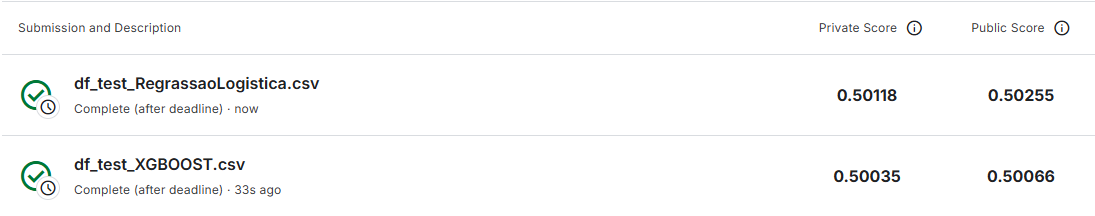

> Diferente dos resultados da avaliação do modelo, a métrica de roc_auc do Regressão Logística foi um pouco maior (0.5026) que o do XGBoost (0.5007)